# Introduction
For this part of the assignment, we are going to use the corridor environment, which has been defined in this notebook. The corridor is shown in the graph below. The reward is -1 per step as usual. The grey block is the terminal state. In each of the three nonterminal states there are only two actions, ***right*** and ***left***. These actions have their usual consequences in the first and third states (left causes no movement in the first state), but in the second state they are reversed, so that right moves to the left and left moves to the right.


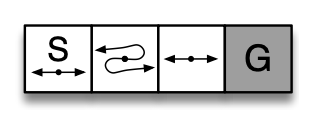

We are going to implment the REINFORCE algorithm and evaluate it on this environment.

In [3]:
#######################################################################
# Copyright (C)                                                       #
# 2018 Sergii Bondariev (sergeybondarev@gmail.com)                    #
# 2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import torch
import torch.nn.functional as F

FRESH_TIME = 0.3    # fresh time for one move

def true_value(p):
    """ True value of the first state
    Args:
        p (float): probability of the action 'right'.
    Returns:
        True value of the first state.
        The expression is obtained by manually solving the easy linear system
        of Bellman equations using known dynamics.
    """
    return (2 * p - 4) / (p * (1 - p)) #v(s)

N_STATES = 4
Render = False

class ShortCorridor:
    """
    Short corridor environment
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.state = 0

    def step(self, go_right):
        """
        Args:
            go_right (bool): chosen action
        Returns:
            tuple of (reward, episode terminated?)
        """
        if self.state == 0 or self.state == 2:
            if go_right:
                self.state += 1
            else:
                self.state = max(0, self.state - 1)
        else:
            if go_right:
                self.state -= 1
            else:
                self.state += 1

        if self.state == 3:
            # terminal state
            return 0, True  # reward
        else:
            return -1, False
        
    def render(self,episode,step_counter):
        env_list = ['-']*(N_STATES-1) + ['T']   # '---------T' our environment
        if self.state == 3:
            interaction = 'Episode %s: total_steps = %s' % (episode+1, step_counter)
            print('\r{}'.format(interaction), end='')
            time.sleep(2)
            print('\r                                ', end='')
        else:
            env_list[self.state] = 'o'
            interaction = ''.join(env_list)
            print('\r{}'.format(interaction), end='')
            time.sleep(FRESH_TIME)
    

def softmax(x):
    t = np.exp(x - np.max(x))
    return t / np.sum(t)



**Question 1: REINFORCE algorithm**

In this part, you need to implement the REINFORCE algorithm. You will need to do the following:        
(1) Initialize a differentiable policy parameterized by $\theta$.                 
(2) Generate an episode with policy. Keep rolling out to get new state s1, reward r and done d from environment until the terminate state.

(3) Calculate returns $G$ for each step of the episode $t = 0, 1, \ldots, T-1$.                         
(4) Update policy.                                                          

Enter your code in the block.

In [83]:

class PolicyNet(torch.nn.Module):
    def __init__(self,obs_dim,act_dim,hidden_dim):
        super(PolicyNet,self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim,act_dim)

    def forward(self,x):
        y = F.relu(self.fc1(x))
        return self.fc2(y)

class ReinforceAgent:
    """
    ReinforceAgent that follows algorithm
    'REINFORNCE Monte-Carlo Policy-Gradient Control (episodic)'
    """

        ##############################################################################
        #                              ENTER YOUR CODE                               #
        ##############################################################################

    def __init__(self):
        # 环境的状态和动作维度
        self.obs_dim = 1
        self.act_dim = 2
        self.hidden_dim = 16
        self.gamma = 0.8
        self.device =torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
        # 存放每个episode的s,a,r
        self.ep_obs,self.ep_act,self.ep_r = [],[],[]
        # 初始化神经网络
        self.actor = PolicyNet(obs_dim = self.obs_dim,act_dim = self.act_dim, hidden_dim = self.hidden_dim).to(self.device)
        self.optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)
        # self.time_step = 0
        
    
    def choose_action(self,obs):
        obs = torch.tensor([obs],dtype=torch.float).to(self.device)   # 转换为torch的格式
        prob = F.softmax(self.actor(obs),dim=0)
        action = np.random.choice(range(self.act_dim),p=prob.detach().cpu().numpy())   # 根据softmax输出的概率来选择动作
        return action
    
    # 存储一个episode的状态、动作和回报的函数
    def store_transition(self,obs,act,r):
        self.ep_obs.append(obs)
        self.ep_act.append(act)
        self.ep_r.append(r)

    # 更新策略网络的函数
    def update(self):
        # self.time_step += 1  # 记录走过的step
        # 记录Gt的值
        discounted_ep_rs = np.zeros_like(self.ep_r,dtype = float)
        running_add = 0
        # 计算未来总收益
        for t in reversed(range(0,len(self.ep_r))):  # 反向计算
            running_add = running_add * self.gamma + self.ep_r[t]
            discounted_ep_rs[t] = running_add

        discounted_ep_rs -= np.mean(discounted_ep_rs)  # 减均值
        discounted_ep_rs /= np.std(discounted_ep_rs)  # 除以标准差
        discounted_ep_rs = torch.FloatTensor(discounted_ep_rs).to(self.device)

        # 输出网络计算出的每个动作的概率值
        act_logit = self.actor(torch.FloatTensor(self.ep_obs).reshape(-1,1).to(self.device))
        
        # 进行交叉熵的运算
        neg_log_prob = F.cross_entropy(input = act_logit,target=torch.LongTensor(self.ep_act).to(self.device),reduction = 'none')
        # neg_log_prob = torch.sum(-F.log_softmax(act_logit) * torch.nn.functional.one_hot(torch.LongTensor(self.ep_act).to(self.device), self.act_dim), dim=1)
        # 计算loss
        loss = torch.mean(neg_log_prob * discounted_ep_rs)

        # 反向传播优化网络
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 每次学习后清空s,r,a的数组
        self.ep_r,self.ep_act,self.ep_obs = [],[],[]


EPISODE = 3000
RENDER = False

if __name__ == '__main__':
    env = ShortCorridor()
    # 初始化ReinforceAgent类
    agent = ReinforceAgent()
    # 进行训练
    reward_total =[]
    for episode in range(EPISODE):
            env.reset()
            obs = env.state
            
            rewards = 0
            step_count = 0
            while True:
                # 与环境的交互
                step_count += 1
                action = agent.choose_action(obs)
                reward,done = env.step(action)
                next_obs = env.state
                # 存储一个episode中每个step的s,a,r
                agent.store_transition(obs,action,reward)
                # 进入下一个状态
                obs = next_obs
                rewards += reward
                # 每个episode结束再进行训练(MC)
                if RENDER and (episode+1) % 100 == 0 and episode !=0:
                    env.render(episode,step_count)
                if done:
                    agent.update()
                    break     
            reward_total.append(rewards)
            # 每100个episode进行测试
            if (episode+1) % 100 == 0 and episode !=0:
                avg_reward = np.mean(reward_total[-100:])
                print('Episode: ',episode+1,'rewards: ',avg_reward)





Episode:  100 rewards:  -9.86
Episode:  200 rewards:  -8.02
Episode:  300 rewards:  -8.39
Episode:  400 rewards:  -7.62
Episode:  500 rewards:  -7.28
Episode:  600 rewards:  -6.63
Episode:  700 rewards:  -5.79
Episode:  800 rewards:  -5.65
Episode:  900 rewards:  -5.91
Episode:  1000 rewards:  -5.55
Episode:  1100 rewards:  -4.65
Episode:  1200 rewards:  -5.29
Episode:  1300 rewards:  -5.35
Episode:  1400 rewards:  -5.04
Episode:  1500 rewards:  -4.72
Episode:  1600 rewards:  -4.96
Episode:  1700 rewards:  -5.21
Episode:  1800 rewards:  -6.16
Episode:  1900 rewards:  -5.94
Episode:  2000 rewards:  -5.68
Episode:  2100 rewards:  -5.65
Episode:  2200 rewards:  -6.27
Episode:  2300 rewards:  -6.42
Episode:  2400 rewards:  -5.86
Episode:  2500 rewards:  -5.68
Episode:  2600 rewards:  -6.57
Episode:  2700 rewards:  -6.16
Episode:  2800 rewards:  -5.55
Episode:  2900 rewards:  -6.23
Episode:  3000 rewards:  -7.43


**Question 2: REINFORCE with baseline (episodic)**

In this section, you need to implement another version of REINFORCE with baseline. Addition to the implementation in vanilla REINFORCE, you need to add a differentiable state-value function w, which is initialized as self.w = 0. You need to use this w as the baseline to reduce the variance of REINFORCE by replacing $G$ with advantage $\delta = G - w$. Then you can update w and $\theta$ as

$\begin{aligned}
& \mathbf{w} \leftarrow \mathbf{w}+\alpha^{\mathbf{w}} \delta \nabla \hat{v}\left(S_t, \mathbf{w}\right) \\
& \boldsymbol{\theta} \leftarrow \boldsymbol{\theta}+\alpha^{\boldsymbol{\theta}} \gamma^t \delta \nabla \ln \pi\left(A_t \mid S_t, \boldsymbol{\theta}\right)
\end{aligned}$.

For more details about the algorithm, refer to the lecture notes LN17 or Chapter 13 "REINFORCE with Baseline (episodic)" in the book "Reinforcement learning: an introduction" by Richard Sutton.

Enter your code in the block.

In [82]:


class PolicyNet(torch.nn.Module):
    def __init__(self,obs_dim,act_dim,hidden_dim):
        super(PolicyNet,self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim,act_dim)

    def forward(self,x):
        y = F.relu(self.fc1(x))
        return self.fc2(y)

class ValueNet(torch.nn.Module):
    def __init__(self,obs_dim,hidden_dim):
        super(ValueNet,self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim,1)

    def forward(self,x):
        y = F.relu(self.fc1(x))
        return self.fc2(y)


class ReinforceBaselineAgent():
        ##############################################################################
        #                             ENTER YOUR CODE                               #
        ##############################################################################
    def __init__(self):
        # 环境的状态和动作维度
        self.obs_dim = 1
        self.act_dim = 2
        self.hidden_dim = 16
        self.gamma = 0.9
        self.device =torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
        # 存放每个episode的s,a,r
        self.ep_obs,self.ep_act,self.ep_r = [],[],[]
        # 初始化神经网络
        self.actor = PolicyNet(obs_dim = self.obs_dim,act_dim = self.act_dim, hidden_dim = self.hidden_dim).to(self.device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-3)
        self.value = ValueNet(obs_dim = self.obs_dim,hidden_dim = self.hidden_dim).to(self.device)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=1e-3)

        # self.time_step = 0
        
    
    def choose_action(self,obs):
        obs = torch.tensor([obs],dtype=torch.float).to(self.device)   # 转换为torch的格式
        prob = F.softmax(self.actor(obs),dim=0)
        action = np.random.choice(range(self.act_dim),p=prob.detach().cpu().numpy())   # 根据softmax输出的概率来选择动作
        return action
    
    # 存储一个episode的状态、动作和回报的函数
    def store_transition(self,obs,act,r):
        self.ep_obs.append(obs)
        self.ep_act.append(act)
        self.ep_r.append(r)

    # 更新策略网络的函数
    def update(self):
        # self.time_step += 1  # 记录走过的step
        # 记录Gt的值
        obs = torch.FloatTensor(self.ep_obs).reshape(-1,1).to(self.device)
        discounted_ep_rs = np.zeros_like(self.ep_r,dtype = float)
        running_add = 0
        # 计算未来总收益
        for t in reversed(range(0,len(self.ep_r))):  # 反向计算
            running_add = running_add * self.gamma + self.ep_r[t]
            discounted_ep_rs[t] = running_add
        v = self.value(obs)
        # v = (v-v.mean())/(v.std()+1e-5)
        discounted_ep_rs = torch.FloatTensor(discounted_ep_rs).reshape(-1,1).to(self.device)
        # discounted_ep_rs_norm = (discounted_ep_rs-discounted_ep_rs.mean())/(discounted_ep_rs.std()+1e-5)
 
        # 输出网络计算出的每个动作的概率值
        act_logit = self.actor(obs)
        
        # 进行交叉熵的运算
        neg_log_prob = F.cross_entropy(input = act_logit,target=torch.LongTensor(self.ep_act).to(self.device),reduction = 'none')
        # neg_log_prob = torch.sum(-F.log_softmax(act_logit) * torch.nn.functional.one_hot(torch.LongTensor(self.ep_act).to(self.device), self.act_dim), dim=1)
        # 计算loss
        

        actor_loss = torch.mean(neg_log_prob * (discounted_ep_rs-v))
        value_loss = F.mse_loss(self.value(obs), discounted_ep_rs)


        # 反向传播优化网络
        self.actor_optimizer.zero_grad()
        self.value_optimizer.zero_grad()
        actor_loss.backward()
        value_loss.backward()
        self.actor_optimizer.step()
        self.value_optimizer.step()

        # 每次学习后清空s,r,a的数组
        self.ep_r,self.ep_act,self.ep_obs = [],[],[]


EPISODE = 3000
RENDER = False

if __name__ == '__main__':
    env = ShortCorridor()
    # 初始化RF类
    agent = ReinforceBaselineAgent()
    # 进行训练
    reward_total =[]
    for episode in range(EPISODE):
            env.reset()
            obs = env.state
            rewards = 0
            step_count = 0
            while True:
                # 与环境的交互
                step_count += 1
                action = agent.choose_action(obs)
                reward,done = env.step(action)
                next_obs = env.state
                # 存储一个episode中每个step的s,a,r
                agent.store_transition(obs,action,reward)
                # 进入下一个状态
                obs = next_obs
                rewards += reward
                # 每个episode结束再进行训练(MC)
                if RENDER and (episode+1) % 100 == 0 and episode !=0:
                    env.render(episode,step_count)
                if done:
                    agent.update()
                    break
            reward_total.append(rewards)
            # 每100个episode进行测试
            if (episode+1) % 100 == 0 and episode !=0:
                print('Episode: ',episode+1,'rewards: ',np.mean(reward_total[-100:]))









Episode:  100 rewards:  -13.78
Episode:  200 rewards:  -13.51
Episode:  300 rewards:  -12.87
Episode:  400 rewards:  -13.33
Episode:  500 rewards:  -10.64
Episode:  600 rewards:  -9.11
Episode:  700 rewards:  -8.78
Episode:  800 rewards:  -8.38
Episode:  900 rewards:  -9.2
Episode:  1000 rewards:  -7.73
Episode:  1100 rewards:  -6.87
Episode:  1200 rewards:  -8.08
Episode:  1300 rewards:  -6.95
Episode:  1400 rewards:  -6.44
Episode:  1500 rewards:  -6.19
Episode:  1600 rewards:  -5.85
Episode:  1700 rewards:  -5.64
Episode:  1800 rewards:  -4.08
Episode:  1900 rewards:  -4.23
Episode:  2000 rewards:  -4.0
Episode:  2100 rewards:  -4.32
Episode:  2200 rewards:  -4.53
Episode:  2300 rewards:  -3.75
Episode:  2400 rewards:  -3.67
Episode:  2500 rewards:  -3.44
Episode:  2600 rewards:  -3.78
Episode:  2700 rewards:  -3.56
Episode:  2800 rewards:  -3.39
Episode:  2900 rewards:  -3.25
Episode:  3000 rewards:  -3.12


**Question 3.1: Evaluation with different learning rate in REINFORCE**

In this part, we will show the performance of REINFORCE on the short-corridor gridworld with different hyperparameter $\alpha$ settings as {2e-3, 2e-4, 2e-5}. The number of trials is 100, and the number of episode is 1000. Discount rate is  $\gamma=1$.

You need to plot the results which show the total reward on episode with these three different learning rates, which is averaged over 100 runs.

In [4]:
def plot_return(alpha_list,reward_alpha,num_episodes):
    reward_alpha = reward_alpha.reshape(-1,num_episodes)
    print('length of episodes: ', num_episodes)
    for i in range(len(alpha_list)):
        plt.plot(np.arange(1, num_episodes+1), reward_alpha[i], label=f"alpha={alpha_list[i]}")
    plt.legend() 
    plt.ylabel('return')
    plt.xlabel('Episodes #')
    plt.show()

In [7]:
class PolicyNet(torch.nn.Module):
    def __init__(self,obs_dim,act_dim,hidden_dim):
        super(PolicyNet,self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim,act_dim)

    def forward(self,x):
        y = F.relu(self.fc1(x))
        return self.fc2(y)

class ReinforceAgent():
    """
    ReinforceAgent that follows algorithm
    'REINFORNCE Monte-Carlo Policy-Gradient Control (episodic)'
    """

        ##############################################################################
        #                              ENTER YOUR CODE                               #
        ##############################################################################

    def __init__(self,lr_actor,gamma):
        # 环境的状态和动作维度
        self.obs_dim = 1
        self.act_dim = 2
        self.hidden_dim = 16
        self.gamma = gamma
        self.device =torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
        # 存放每个episode的s,a,r
        self.ep_obs,self.ep_act,self.ep_r = [],[],[]
        # 初始化神经网络
        self.actor = PolicyNet(obs_dim = self.obs_dim,act_dim = self.act_dim, hidden_dim = self.hidden_dim).to(self.device)
        self.optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        # self.time_step = 0
        
    
    def choose_action(self,obs):
        obs = torch.tensor([obs],dtype=torch.float).to(self.device)   # 转换为torch的格式
        prob = F.softmax(self.actor(obs),dim=0)
        action = np.random.choice(range(self.act_dim),p=prob.detach().cpu().numpy())   # 根据softmax输出的概率来选择动作
        return action
    
    # 存储一个episode的状态、动作和回报的函数
    def store_transition(self,obs,act,r):
        self.ep_obs.append(obs)
        self.ep_act.append(act)
        self.ep_r.append(r)

    # 更新策略网络的函数
    def update(self):
        # self.time_step += 1  # 记录走过的step
        # 记录Gt的值
        discounted_ep_rs = np.zeros_like(self.ep_r,dtype = float)
        running_add = 0
        # 计算未来总收益
        for t in reversed(range(0,len(self.ep_r))):  # 反向计算
            running_add = running_add * self.gamma + self.ep_r[t]
            discounted_ep_rs[t] = running_add

        discounted_ep_rs -= np.mean(discounted_ep_rs)  # 减均值
        discounted_ep_rs /= np.std(discounted_ep_rs)  # 除以标准差
        discounted_ep_rs = torch.FloatTensor(discounted_ep_rs).to(self.device)

        # 输出网络计算出的每个动作的概率值
        act_logit = self.actor(torch.FloatTensor(self.ep_obs).reshape(-1,1).to(self.device))
        
        # 进行交叉熵的运算
        neg_log_prob = F.cross_entropy(input = act_logit,target=torch.LongTensor(self.ep_act).to(self.device),reduction = 'none')
        # neg_log_prob = torch.sum(-F.log_softmax(act_logit) * torch.nn.functional.one_hot(torch.LongTensor(self.ep_act).to(self.device), self.act_dim), dim=1)
        # 计算loss
        loss = torch.mean(neg_log_prob * discounted_ep_rs)

        # 反向传播优化网络
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 每次学习后清空s,r,a的数组
        self.ep_r,self.ep_act,self.ep_obs = [],[],[]


RENDER = False

def Q3_1():
    num_trials = 100
    num_episodes = 1000
    gamma = 1
    alpha_list = [2e-3, 2e-4, 2e-5]
    ##############################################################################
    #                             ENTER YOUR CODE                               #
    ##############################################################################
    env = ShortCorridor()
    # 初始化ReinforceAgent类
    
    # 进行训练
    reward_alpha = np.zeros((len(alpha_list),num_episodes))
    for alpha in alpha_list:
        agent = ReinforceAgent(alpha,gamma)
        reward_total = []
        with tqdm(total=int(num_trials), desc='alpha= %f' % alpha) as pbar:
            for trial in range(num_trials):
                reward_total_episode = []
                
                for episode in range(num_episodes):
                        env.reset()
                        obs = env.state
                        rewards = 0
                        step_count = 0
                        while True:
                            # 与环境的交互
                            step_count += 1
                            action = agent.choose_action(obs)
                            reward,done = env.step(action)
                            next_obs = env.state
                            # 存储一个episode中每个step的s,a,r
                            agent.store_transition(obs,action,reward)
                            # 进入下一个状态
                            obs = next_obs
                            rewards += reward
                            # 每个episode结束再进行训练(MC)
                            if RENDER and (episode+1) % 100 == 0 and episode !=0:
                                env.render(episode,step_count)
                            if done:
                                agent.update()
                                break     
                        reward_total_episode.append(rewards)
                reward_total.append(reward_total_episode)
                pbar.set_postfix({'trial': '%d' % (trial+1)})
                pbar.update(1)
            reward_total_average = np.array(reward_total).reshape(num_trials,-1).mean(axis=0)
            reward_alpha[alpha_list.index(alpha)] = reward_total_average
    plot_return(alpha_list,reward_alpha,num_episodes)    
    
                        # 每100个episode进行测试
                        # if (episode+1) % 100 == 0 and episode !=0:
                        #     avg_reward = np.mean(reward_total[-100:])
                        #     print('Episode: ',episode+1,'rewards: ',avg_reward)


alpha= 0.000020: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s, trial=100]

length of episodes:  1000


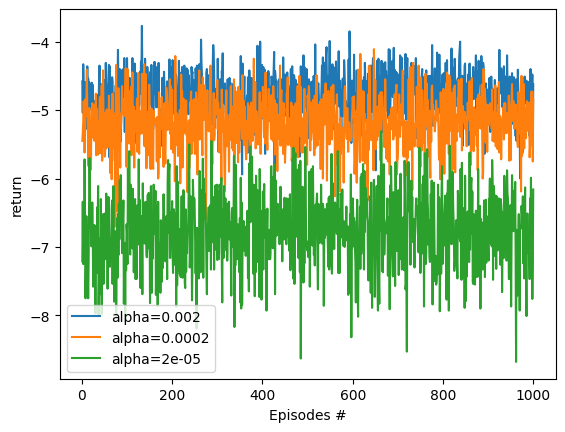

In [8]:
Q3_1()

**Question 3.2: Evaluation of REINFORCE w/o baseline**

In this part, we will show the performance of REINFORCE and REINFORCE-with-baseline on the short-corridor gridworld. The hyperparameter $\alpha$ for REINFORCE is set as {2e-4}. The hyperparameter $\alpha, \alpha^w$ for REINFORCE with baseline is set as {2e-3, 2e-2}. The number of trials is 100, and the number of episode is 1000. Discount rate is  $\gamma=1$.

You need to plot the results which show the total reward on episode with these three different learning rates, which is averaged over 100 runs.

In [9]:
class PolicyNet(torch.nn.Module):
    def __init__(self,obs_dim,act_dim,hidden_dim):
        super(PolicyNet,self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim,act_dim)

    def forward(self,x):
        y = F.relu(self.fc1(x))
        return self.fc2(y)

class ValueNet(torch.nn.Module):
    def __init__(self,obs_dim,hidden_dim):
        super(ValueNet,self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim,1)

    def forward(self,x):
        y = F.relu(self.fc1(x))
        return self.fc2(y)


class ReinforceBaselineAgent():
        ##############################################################################
        #                             ENTER YOUR CODE                               #
        ##############################################################################
    def __init__(self,alpha,alpha_actor,gamma):
        # 环境的状态和动作维度
        self.obs_dim = 1
        self.act_dim = 2
        self.hidden_dim = 16
        self.gamma = gamma
        self.device =torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
        # 存放每个episode的s,a,r
        self.ep_obs,self.ep_act,self.ep_r = [],[],[]
        # 初始化神经网络
        self.actor = PolicyNet(obs_dim = self.obs_dim,act_dim = self.act_dim, hidden_dim = self.hidden_dim).to(self.device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=alpha_actor)
        self.value = ValueNet(obs_dim = self.obs_dim,hidden_dim = self.hidden_dim).to(self.device)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=alpha)

        # self.time_step = 0
        
    
    def choose_action(self,obs):
        obs = torch.tensor([obs],dtype=torch.float).to(self.device)   # 转换为torch的格式
        prob = F.softmax(self.actor(obs),dim=0)
        action = np.random.choice(range(self.act_dim),p=prob.detach().cpu().numpy())   # 根据softmax输出的概率来选择动作
        return action
    
    # 存储一个episode的状态、动作和回报的函数
    def store_transition(self,obs,act,r):
        self.ep_obs.append(obs)
        self.ep_act.append(act)
        self.ep_r.append(r)

    # 更新策略网络的函数
    def update(self):
        # self.time_step += 1  # 记录走过的step
        # 记录Gt的值
        obs = torch.FloatTensor(self.ep_obs).reshape(-1,1).to(self.device)
        discounted_ep_rs = np.zeros_like(self.ep_r,dtype = float)
        running_add = 0
        # 计算未来总收益
        for t in reversed(range(0,len(self.ep_r))):  # 反向计算
            running_add = running_add * self.gamma + self.ep_r[t]
            discounted_ep_rs[t] = running_add
        v = self.value(obs)
        # v = (v-v.mean())/(v.std()+1e-5)
        discounted_ep_rs = torch.FloatTensor(discounted_ep_rs).reshape(-1,1).to(self.device)
        # discounted_ep_rs_norm = (discounted_ep_rs-discounted_ep_rs.mean())/(discounted_ep_rs.std()+1e-5)
 
        # 输出网络计算出的每个动作的概率值
        act_logit = self.actor(obs)
        
        # 进行交叉熵的运算
        neg_log_prob = F.cross_entropy(input = act_logit,target=torch.LongTensor(self.ep_act).to(self.device),reduction = 'none')
        # neg_log_prob = torch.sum(-F.log_softmax(act_logit) * torch.nn.functional.one_hot(torch.LongTensor(self.ep_act).to(self.device), self.act_dim), dim=1)
        # 计算loss
        

        actor_loss = torch.mean(neg_log_prob * (discounted_ep_rs-v))
        value_loss = F.mse_loss(self.value(obs), discounted_ep_rs)


        # 反向传播优化网络
        self.actor_optimizer.zero_grad()
        self.value_optimizer.zero_grad()
        actor_loss.backward()
        value_loss.backward()
        self.actor_optimizer.step()
        self.value_optimizer.step()

        # 每次学习后清空s,r,a的数组
        self.ep_r,self.ep_act,self.ep_obs = [],[],[]

def Q3_2():
    num_trials = 100
    num_episodes = 1000
    alpha_actor = 2e-4
    gamma = 1
    alpha_w = [2e-3,2e-2]
    RENDER = False

    ##############################################################################
    #                             ENTER YOUR CODE                               #
    ##############################################################################
    env = ShortCorridor()
    # 初始化ReinforceAgent类
    
    # 进行训练
    reward_alpha = reward_alpha = np.zeros((len(alpha_w),num_episodes))
    
    for alpha in alpha_w:
        agent = ReinforceBaselineAgent(alpha,alpha_actor,gamma)
        reward_total =[]
        with tqdm(total=int(num_trials), desc='alpha= %f' % alpha) as pbar:
            for trial in range(num_trials):
                reward_total_episode = []
                for episode in range(num_episodes):
                        env.reset()
                        obs = env.state
                        rewards = 0
                        step_count = 0
                        while True:
                            # 与环境的交互
                            step_count += 1
                            action = agent.choose_action(obs)
                            reward,done = env.step(action)
                            next_obs = env.state
                            # 存储一个episode中每个step的s,a,r
                            agent.store_transition(obs,action,reward)
                            # 进入下一个状态
                            obs = next_obs
                            rewards += reward
                            # 每个episode结束再进行训练(MC)
                            if RENDER and (episode+1) % 100 == 0 and episode !=0:
                                env.render(episode,step_count)
                            if done:
                                agent.update()
                                break     
                        reward_total_episode.append(rewards)
                reward_total.append(reward_total_episode)
                pbar.set_postfix({'trial': '%d' % (trial+1)})
                pbar.update(1)
            reward_total_average = np.array(reward_total).reshape(num_trials,-1).mean(axis=0)
            reward_alpha[alpha_w.index(alpha)] = reward_total_average
    
    plot_return(alpha_w,reward_alpha,num_episodes)



alpha= 0.020000: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s, trial=100]

length of episodes:  1000


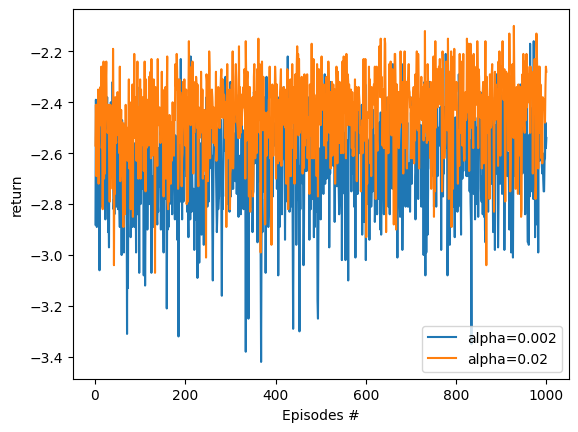

In [10]:
Q3_2()